## Five minutes With AI: OpenPose

Today we will use a tool to detect human body, hand, facial, and foot keypoints (in total 135 keypoints) from images/videos. It is called [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose).

## Before we get started, let me introduce this experiment notebook.

This is a *jupyter notebook*. It is like a lab notebook, but has a programming feature.

A notebook is a list of *cells*. Each cell can be one of:
* code - in this case, python code
* markdown or text: your notes about what you are doing

To run a code cell, use Shift+Enter (hold down the Shift and Enter keys at once). 

If you'd like help with notebooks, we are here.

## Why do we like OpenPose?

Here are some things we like about OpenPose:
* It can be used to detect 25 body keypoints, 21 hand key points, and 70 face key points from images and videos.
* It is free and regularly maintained (that means if one library that OpenPose relies on changes, it is fixed pretty fast).
* It can represent human activity in a video through body keypoints, wihout revealing individually identifiable information.
* Keypoints detected from video using OpenPose can be used for applications in fitness, sports, activity, perfroming arts, etc. 


You don't need to first become a computer scientist and figure out how to prepare your video to run OpenPose on it and visualize the result. OpenPose already has those features. 

If you are interested to access a table containing all the data used for visualization.we also include a code sample to do that in this notebook. 

To know more about the keypoints, [see here](https://cmu-perceptual-computing-lab.github.io/openpose/web/html/doc/md_doc_02_output.html).



## What we don't like about OpenPose?

* It works well with images, but is slow for longer videos (you can select to sample video frames to speed it up, but you will need GPUs). 

* OpenPose works well for single-person video, but can confuse the identities of people if multiple persons are present (especially if the persons overlap during the video).

## How does OpenPose work?

* It first extracts interesting features from a picture using a neural network.

* A second network then predicts  confidence maps for each specific part of the human pose skeleton. 

* Then it finds the level of association between parts as a graph.

* If there are overlapping association predicted, it prunes that graph with the help of the confidence maps from step 2.

* In the final step, human pose skeletons are estimated and allocated to every person in the picture.


## Okay, Let's see how to use it?

## Before we start...

* Go to the top menu and select 'Runtime'.
* From the dropdown menu, click on 'Change Runtime Type'
* From the menu of 'Hardware accelerator 
', select **GPU**.

By running this notebook on GPU, we will get our analysis faster.

## First we install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`


## Second we get a video for this example
### We will use a video from Youtube

In [ ]:
# this library allow accessing videos from you tube
!pip install yt-dlp
from IPython.display import YouTubeVideo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### We will use this video of a contemporary dance performance available [here](https://www.youtube.com/watch?v=91sd4Jnwgjs).
Let's take a look at it first 

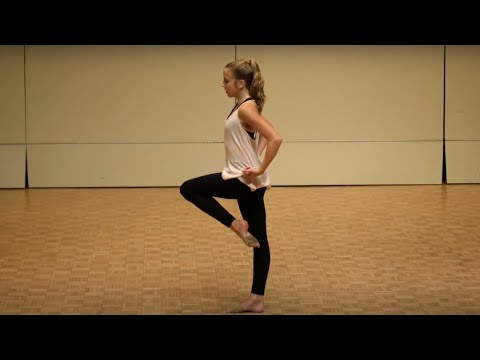

In [ ]:
YOUTUBE_ID = '91sd4Jnwgjs' # this is the youtube id of the video
YouTubeVideo(YOUTUBE_ID)

## Now that we have a video, let's download it to our Google Drive so that OpenPose can access it

In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!yt-dlp -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 90 video.mp4
# detect poses on the these 5 seconds
!rm openpose.avi

[youtube] Extracting URL: https://www.youtube.com/watch?v=91sd4Jnwgjs
[youtube] 91sd4Jnwgjs: Downloading webpage
[youtube] 91sd4Jnwgjs: Downloading android player API JSON
[info] 91sd4Jnwgjs: Downloading 1 format(s): 136
[download] Destination: youtube.mp4
[download] 100% of   18.05MiB in 00:00:00 at 64.57MiB/s
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-li

## Let's run OpenPose on it

### This is going to take a few minutes ...

In [ ]:
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 214.462320 seconds.
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-lib

## Let's look at the result video using the visualizer OpenPose provides

In [ ]:
def show_local_mp4_video(file_name, width=300, height=200):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=300, height=200)

Output hidden; open in https://colab.research.google.com to view.

## Want to access the body keypoints as a table to do further analysis?

### The code below will save a table and show the keypoints in a tabular format.

In [1]:
import os
import json
import pandas as pd
import numpy as np

# The directory where openpose store keypoints from each frame
json_path =  './openpose/output/'
json_files = sorted([x for x in os.listdir(json_path) if x.endswith("json")])


body = []
for file in json_files[20:]:
    filename = json_path + '/'  + file
    df = pd.read_json(filename)

    try: 
      pose = df.iloc[0]['people']['pose_keypoints_2d']

      #getting x, y cordinate from original openpose format (x, y, confidence)
      x = pose[0::3]
      y = pose[1::3]
    
      #x, y
      features_x = []
      features_y = []
      for i, j in zip(x, y):
          features_x.append(i)
          features_y.append(j)

      features = [[i, j] for (i,j) in zip(features_x, features_y)]

      # x, y from 25 keypoints = 50 values
      features = np.reshape(features, (1, 50))

      feature_columns = ["Nose_x", "Nose_y",  "Neck_x", "Neck_y",  "RShoulder_x", "RShoulder_y", "RElbow_x", "RElbow_y", "RWrist_x", "RWrist_y", "LShoulder_x", "LShoulder_y", "LElbow_x", "LElbow_x", "LWrist_y", "LWrist_x", "MidHip_x", "MidHip_y", "RHip_x", "RHip_y", "RKnee_x", "RKnee_y", "RAnkle_x", "RAnkle_y", "LHip_x", "LHip_y",  "LKnee_x", "LKnee_y", "LAnkle_x",  "LAnkle_y", "REye_x",  "REye_y", "LEye_x",  "LEye_y", "REar_x", "REar_y" ,"LEar_x", "LEar_y", "LBigToe_x", "LBigToe_y", "LSmallToe_x", "LSmallToe_y", "LHeel_x", "LHeel_y", "RBigToe_x", "RBigToe_y", "RSmallToe_x", "RSmallToe_y", "RHeel_x", "RHeel_y"]
    
      data = pd.DataFrame(features, index= [0], columns=feature_columns)
    
    #in case there is no person present in a frame
    except:
       data = pd.DataFrame(0, index=np.arange(len(data)), columns=feature_columns)
        
    body.append(data)
                    
    body_df = pd.concat(body, axis=0, ignore_index = 1)
        
    body_df.to_csv('body.csv')
        


FileNotFoundError: ignored

## Let's look at the keypoints

In [2]:
bodypose = pd.read_csv('body.csv', index_col= [0])
bodypose

FileNotFoundError: ignored

### How are we using OpenPose?

We are using OpenPose to identify body movements from the keypoints and explore how to use them for:
* understanding interaction and alignment during a conversation
* understanding non-verbal cues when interacting with neuro-divergent children.

## I am curious to know more!

If you like OpenPose, we have other great resources coming up.
* If you have audio, we can introduce you to [Whisper](https://colab.research.google.com/drive/1yAHySBUs6W5GRrJfg4IrSrDn-tAeMCE1?usp=sharing) to get the transcript.

* If you have video containing, we can introduce you to [Py-Feat](https://colab.research.google.com/drive/1lCiTDUp8YHUB9g6UHN4w7W3nZJOCOLUa?usp=sharing) to get facial landmarks and expressions.

* For the *audio*, we can add extraction of acoustic/prosodic features.
* Once you have a *transcript*, we can add NLP to identify sentiment, named entities, and more.

## End Note
If you use OpnePose, PyFeat or Whisper, please let us know. We want to work with you! 
We want to know what works and what doesn't! We want to understand your joys and your concerns.